In [124]:
import os
from pynq import Overlay
from pynq import allocate
import xrfclk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from axififo import AxiStreamFifoDriver
import scipy.signal
import scipy.io
import time
import serial
from datetime import datetime

In [2]:
ol = Overlay("hw/top_20240111_104744.bit", download=True)
xrfclk.set_ref_clks(lmk_freq=122.88, lmx_freq=409.6)

In [64]:
dac_fsamp = 6.144e9 #Hz
dds_phase_bits = 32
scale_bits = 18
scale_frac_bits = 16

verbose = False

adc_fsamp = 4.096e9 # Hz

awg_frame_depth = 2048 # multiply by 16 to get total samples
adc_buffer_data_depth = 2048
adc_buffer_tstamp_depth = 512
tstamp_width = 64

parallel_samples = 16
sample_width = 16
num_channels = 8

awg_dma = ol.axi_dma_0.sendchannel
adc_dma = ol.axi_dma_0.recvchannel
# 8x2048-deep data buffer (256b/word)
# 8x512-deep timestamp buffer (64b/word)
# information:
# 8x2x(64+256)
adc_dma_bits = num_channels*adc_buffer_data_depth*parallel_samples*sample_width # data buffer
adc_dma_bits += num_channels*adc_buffer_tstamp_depth*tstamp_width # timestamp buffer
adc_dma_bits += num_channels*2*(parallel_samples*sample_width+tstamp_width) # timestamp+data channel ID/ sample count info
adc_buffer = allocate(shape=(adc_dma_bits//64,), dtype=np.uint64)
# 8 x awg_frame_depth - deep data buffer (256b/word, 16 samples/word)
awg_buffer = allocate(shape=(num_channels*awg_frame_depth*parallel_samples,), dtype=np.uint16)

def packetize(long_word, num_words):
    packet = []
    if verbose:
        print(f'packetizing word {long_word:#0{num_words*8}x} into {num_words} words')
    for word in range(num_words):
        packet.append(long_word & ((1 << 32) - 1))
        long_word >>= 32
    return packet

def receive_adc_data():
    adc_dma.transfer(adc_buffer)
    
def send_awg_data():
    awg_dma.transfer(awg_buffer)
    
def set_dac_scale(scales):
    scale_word = 0
    for channel in range(num_channels):
        # scale is 2Q16, so quantize appropriately
        quant = int(scales[channel] * 2**scale_frac_bits)
        if (quant >> scale_frac_bits) > 1 or (quant >> scale_frac_bits) < -2:
            raise ValueError(f'cannot quantize {scale} to {scale_bits-scale_frac_bits}Q{scale_frac_bits}')
        if quant < 0:
            quant += 2**scale_bits
        scale_word |= quant << (scale_bits * channel)
    ol.dac_scale_config.fifo.send_tx_pkt(packetize(scale_word, (int(np.ceil(scale_bits/4))*4 * num_channels) // 32))

def set_dds_freq(freqs_hz):
    pinc_word = 0
    for channel in range(num_channels):
        pinc = int((freqs_hz[channel]/dac_fsamp)*(2**dds_phase_bits))
        pinc_word |= pinc << (dds_phase_bits * channel)
    ol.dds_phase_inc.fifo.send_tx_pkt(packetize(pinc, (dds_phase_bits * num_channels) // 32))
    
def set_awg_triggers(trigger_modes):
    trigger_word = 0
    for channel in range(num_channels):
        if trigger_modes[channel] not in range(0,3):
            raise ValueError(f'invalid selection for trigger mode ({trigger_modes[channel]}) on channel ({channel})')
        trigger_word |= trigger_modes[channel] << (2*channel)
    ol.awg_trigger_out_config.fifo.send_tx_pkt([trigger_word])
    
def set_awg_burst_length(burst_lengths):
    packet = []
    for channel in range(num_channels):
        packet.append(burst_lengths[channel] & ((1 << 32) - 1))
        packet.append((burst_lengths[channel] >> 32) & ((1 << 32) - 1))
    ol.awg_burst_length.fifo.send_tx_pkt(packet)
    
def set_awg_frame_depth(depths):
    frame_depth_word = 0
    for channel in range(num_channels):
        if depths[channel] not in range(0, 2049):
            raise ValueError(f'invalid frame depth ({depths[channel]}) for channel ({channel})')
        frame_depth_word |= depths[channel] << (12*channel)
    if verbose:
        print(f'frame_depth word = {frame_depth_word:#024x}')
    ol.awg_frame_depth.fifo.send_tx_pkt(packetize(frame_depth_word, (12*num_channels)//32))

def start_awg():
    ol.awg_start_stop.fifo.send_tx_pkt([2])
    
def stop_awg():
    ol.awg_start_stop.fifo.send_tx_pkt([1])

def start_adc_buffer():
    ol.buffer_start_stop.fifo.send_tx_pkt([0x2])
    
def stop_adc_buffer():
    ol.buffer_start_stop.fifo.send_tx_pkt([0x1])

def sink_select_all_adcs():
    ol.adc_mux_config.fifo.send_tx_pkt([0x76543210])
    
def source_select_all_dds():
    ol.dac_mux_config.fifo.send_tx_pkt([0xfedcba98])
    
def source_select_all_awg():
    ol.dac_mux_config.fifo.send_tx_pkt([0x76543210])

def set_buffer_num_active_channels(num_active_channels):
    # todo accomodate more than 8 channels
    if num_active_channels not in [1,2,4,8]:
        raise ValueError(f'Incorrect number of active channels: {num_active_channels}, expected one of [1,2,4,8]')
    banking_mode = int(np.ceil(np.log2(num_active_channels)))
    ol.buffer_config.fifo.send_tx_pkt([banking_mode])

def set_sample_discriminator_config(low_thresholds, high_thresholds):
    packet = []
    for channel in range(8):
        low = low_thresholds[channel]
        high = high_thresholds[channel]
        if low not in range(0,2**sample_width):
            raise ValueError(f'invalid low_threshold ({hex(low)}) for channel {channel}, should be between 0x00 and 0xff')
        if high not in range(0,2**sample_width):
            raise ValueError(f'invalid high_thresholds ({hex(high)}) for channel {channel}, should be between 0x00 and 0xff')
        packet.append((high << sample_width) | low)
    ol.sample_discriminator_config.fifo.send_tx_pkt(packet)

def set_trigger_manager_config(combine_mode, mask):
    if mask not in range(0, 2**num_channels):
        raise ValueError(f'Incorrect mask value {hex(mask)}, should be an 8-bit quantity')
    if combine_mode.lower() not in ['and', 'or']:
        raise ValueError(f'Incorrect combine mode {combine_mode}, should be and/or (case insensitive)')
    comb_bit = 1 if combine_mode.lower() == 'and' else 0
    ol.trigger_manager_config.fifo.send_tx_pkt([(comb_bit << num_channels) | mask])
    
def parse_adc_data(num_active_channels):
    if num_active_channels not in [1,2,4,8]:
        raise ValueError(f'Incorrect number of active channels: {num_active_channels}, expected one of [1,2,4,8]')
    dma_word = 0
    dma_word_leftover_bits = 0
    dma_buffer_index = 0
    word_width = 64 # until we get the axis-register to work, don't use get_tstamp_width()
    word_mask = (1 << word_width) - 1
    parse_mode = "timestamp"
    need_channel_id = True
    need_word_count = True
    parsed_bank_count = 0
    done_parsing = False
    words_remaining = None
    # TODO generalize for banking mode other than 0x2
    timestamps = [np.zeros((8//num_active_channels)*adc_buffer_tstamp_depth,dtype=np.uint64) for i in range(num_active_channels)]
    samples = [np.zeros((8//num_active_channels)*adc_buffer_data_depth*parallel_samples,dtype=np.int16) for i in range(num_active_channels)]
    timestamp_index = [0 for i in range(num_active_channels)]
    sample_index = [0 for i in range(num_active_channels)]
    while not done_parsing:
        for _ in range(2 if parse_mode == "timestamp" else 4):
            dma_word = (int(adc_buffer[dma_buffer_index]) << dma_word_leftover_bits) | dma_word
            dma_word_leftover_bits += 64 # 64b numpy array
            dma_buffer_index += 1
        while dma_word_leftover_bits >= word_width:
            if need_channel_id:
                current_channel = dma_word & word_mask
                need_channel_id = False
                need_word_count = True
            else:
                if need_word_count:
                    words_remaining = dma_word & word_mask
                    need_word_count = False
                else:
                    if parse_mode == "timestamp":
                        timestamps[current_channel][timestamp_index[current_channel]] = dma_word & word_mask
                        timestamp_index[current_channel] += 1
                    elif parse_mode == "data":
                        for i in range(parallel_samples):
                            samples[current_channel][sample_index[current_channel]] = (dma_word >> (16*i)) & 0xffff
                            sample_index[current_channel] += 1
                    words_remaining -= 1
                if words_remaining == 0:
                    need_channel_id = True
                    parsed_bank_count += 1
            if parsed_bank_count == num_channels:
                if parse_mode == "timestamp":
                    word_width = parallel_samples*16
                    parse_mode = "data"
                else:
                    done_parsing = True
                dma_word = 0
                dma_word_leftover_bits = 0
                parsed_bank_count = 0
            else:
                dma_word >>= word_width
                dma_word_leftover_bits -= word_width
    return timestamps, samples, timestamp_index, sample_index

In [142]:
##########################################
# setup AWG
##########################################
print(f'setting up AWG')
stop_awg() # stop the AWG to make sure we return to DMA_IDLE state
# first set the trigger to output a 1 only at the beginning of a burst, only on channel 0
set_awg_triggers([1] + [0]*7)
# now set burst lengths
set_awg_burst_length([1]*8) # if burst_length = 0, run for 2^64 - 1 cycles, basically forever
# set dac scale and set mux to use AWG
set_dac_scale([0.125]*8) # enable all channels
# set mux to select AWGs
source_select_all_awg()
# generate waveform
for i in range(8):
    pulse_samples = 128*(i+1)
    t = np.linspace(0,1,pulse_samples)
    awg_buffer[i*awg_frame_depth*16+pulse_samples:(i+1)*awg_frame_depth*16] = 0
    #awg_buffer[i*awg_frame_depth*16:i*awg_frame_depth*16+pulse_samples] = 2**15 - 1
    #awg_buffer[i*awg_frame_depth*16+50*pulse_samples:i*awg_frame_depth*16+51*pulse_samples] = 2**15 - 1
    awg_buffer[i*awg_frame_depth*16:i*awg_frame_depth*16+pulse_samples] = (2**14-1)*scipy.signal.sawtooth(4*np.pi*t,width=0.2) + 2**14
##########################################
# setup ADC buffer
##########################################
print(f'setting up ADC buffer')
# set trigger manager configuration:
set_trigger_manager_config('or', 0x1) # OR all channel triggers after applying mask 0x1
sink_select_all_adcs()
set_sample_discriminator_config([2**15]*8, [2**15]*8) # save everything
set_buffer_num_active_channels(8)
##########################################
# set frame depth and do DMA
##########################################
print(f'starting AWG')
# DMA buffer is allocated at 8 x awg_frame_depth x 256b, so set frame length of awg_frame_depth
set_awg_frame_depth([awg_frame_depth]*8)
send_awg_data()
start_awg()
##########################################
# receive data
##########################################
print(f'receiving ADC data')
stop_adc_buffer()
receive_adc_data()
#

setting up AWG
setting up ADC buffer
starting AWG
receiving ADC data


In [143]:
timestamps, samples, timestamp_index, sample_index = parse_adc_data(8)
print(f'got {list(t for t in timestamp_index)} timestamps')

got [1, 1, 1, 1, 1, 1, 1, 1] timestamps


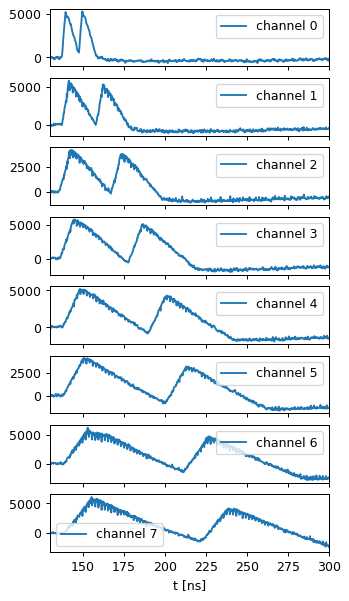

In [144]:
tvec = np.linspace(0,adc_buffer_data_depth*parallel_samples/adc_fsamp,adc_buffer_data_depth*parallel_samples,endpoint=False)
f, ax = plt.subplots(8,1,sharex=True,figsize=(4,8),dpi=90)
for i in range(8):
    ax[i].plot(tvec*1e9, samples[i], label=f'channel {i}')
    ax[i].legend()
ax[0].set_xlim(130, 300)
ax[7].set_xlabel('t [ns]')
f.savefig(f'figures/awg_pulse_test_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', facecolor='white', transparent=False)

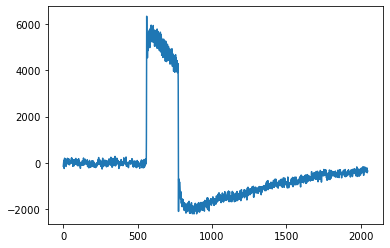

In [66]:
plt.plot(samples[5][:2048])

In [24]:
# send data with DDS
set_all_dds()
set_dds_freq([100e6]*8)
set_dac_scale([0]*7 + [1])

packetizing word 0x000000000000000000000000000000000000000000000000000000042aaaaa into 8 words
packetizing word 0x00400000000000000000000000000000000000 into 5 words


In [3]:
ol?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff8c52e170>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay hw/top.bit. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma_0            : pynq.lib.dma.DMA
usp_rf_data_converter_0 : pynq.overlay.DefaultIP
sample_discriminator_config/fifo : axififo.AxiStreamFifoDriver
buffer_config/fifo   : axififo.AxiStreamFifoDriver
adc_mux_config/fifo  : axififo.AxiStreamFifoDriver
buffer_start_stop/fifo : axififo.AxiStreamFifoDriver
awg_frame_depth/fifo : axififo.AxiStreamFifoDriver
awg_burst_length/fifo : axififo.AxiStreamFifoDriver
awg_start_stop/fifo  : axififo.AxiStreamFifoDriver
awg_trigger_out_config/fifo : axififo.AxiStreamFifoDriver
dac_mux_config/fifo  : axififo.AxiStreamFifoDriver
trigger_manager_config/fifo : axififo.AxiStreamFifoDriver
dac_scale_config/fifo : axififo.AxiStreamFifoDriver
